# 🚀 Complete Adaptive Tutorial Agent - All-in-One Training

**Single notebook with everything you need!**

This notebook contains:
- ✅ All imports and setup
- ✅ TutorialEnvironment (simulated learning)
- ✅ Q-Learning Agent (difficulty adaptation)
- ✅ Policy Gradient Agent (content selection)
- ✅ Training Manager & complete training loop
- ✅ Model saving and download

**Just run all cells sequentially!**

In [1]:
# Install required packages
!pip install torch torchvision numpy matplotlib pickle-mixin

print("✅ Packages installed successfully!")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 114.3 MB/s eta 0:00:00
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.wh

In [2]:
# Import all required libraries
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import time
import os
from collections import defaultdict, deque
from typing import Dict, List, Tuple, Optional, Any

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ All imports successful!
PyTorch version: 2.6.0+cu124
CUDA available: True


In [11]:
# Tutorial Environment - Simulates Student Learning
class TutorialEnvironment:
    def __init__(self, topics=["Math", "Science", "History"],
                 difficulty_levels=["beginner", "intermediate", "advanced"],
                 question_types=["multiple_choice", "short_answer"]):
        self.topics = topics
        self.difficulty_levels = difficulty_levels
        self.question_types = question_types
        self.reset_student_profile()
        self.current_topic = None
        self.current_difficulty = None
        self.current_question_type = None
        self.questions_answered = 0
        self.correct_answers = 0
        self.session_time = 0
        self.max_session_length = 20
        self.state_size = 10  # 4 profile + 3 context + 3 metrics
        print(f"🌍 Tutorial Environment initialized with {len(topics)} topics")

    def get_state_size(self):
        return self.state_size

    def reset_student_profile(self):
        self.student_profile = {
            'knowledge_level': np.random.uniform(0.2, 0.8),
            'engagement': np.random.uniform(0.3, 0.9),
            'difficulty_preference': np.random.uniform(0.3, 0.7),
            'learning_pace': np.random.uniform(0.4, 0.8)
        }

    def reset(self):
        self.reset_student_profile()
        self.current_topic = random.choice(self.topics)
        self.current_difficulty = random.choice(self.difficulty_levels)
        self.current_question_type = random.choice(self.question_types)
        self.questions_answered = 0
        self.correct_answers = 0
        self.session_time = 0
        return self.get_current_state()

    def get_current_state(self):
        profile_features = [self.student_profile['knowledge_level'], self.student_profile['engagement'],
                          self.student_profile['difficulty_preference'], self.student_profile['learning_pace']]
        context_features = [self.topics.index(self.current_topic) / len(self.topics),
                          self.difficulty_levels.index(self.current_difficulty) / len(self.difficulty_levels),
                          self.question_types.index(self.current_question_type) / len(self.question_types)]
        accuracy = self.correct_answers / max(self.questions_answered, 1)
        progress = self.questions_answered / self.max_session_length
        time_ratio = min(self.session_time / 60.0, 1.0)
        session_features = [accuracy, progress, time_ratio]
        return np.array(profile_features + context_features + session_features, dtype=np.float32)

    def step(self, q_action, pg_action):
        self._apply_difficulty_action(q_action)
        self._apply_content_action(pg_action)
        success_probability = self._calculate_success_probability()
        correct = np.random.random() < success_probability
        self.questions_answered += 1
        if correct:
            self.correct_answers += 1
        self._update_student_state(correct, q_action, pg_action)
        reward = self._calculate_reward(correct, q_action, pg_action)
        done = (self.questions_answered >= self.max_session_length or self.student_profile['engagement'] < 0.1)
        info = {'correct': correct, 'success_probability': success_probability, 'current_topic': self.current_topic,
                'current_difficulty': self.current_difficulty, 'questions_answered': self.questions_answered,
                'accuracy': self.correct_answers / self.questions_answered, 'engagement': self.student_profile['engagement'],
                'knowledge_level': self.student_profile['knowledge_level']}
        self.session_time += np.random.uniform(10, 30)
        return self.get_current_state(), reward, done, info

    def _apply_difficulty_action(self, action):
        if action == 0:  # decrease_difficulty
            current_idx = self.difficulty_levels.index(self.current_difficulty)
            if current_idx > 0:
                self.current_difficulty = self.difficulty_levels[current_idx - 1]
        elif action == 1:  # increase_difficulty
            current_idx = self.difficulty_levels.index(self.current_difficulty)
            if current_idx < len(self.difficulty_levels) - 1:
                self.current_difficulty = self.difficulty_levels[current_idx + 1]
        elif action == 3:  # adaptive_difficulty
            pref = self.student_profile['difficulty_preference']
            target_idx = int(pref * len(self.difficulty_levels))
            target_idx = min(target_idx, len(self.difficulty_levels) - 1)
            self.current_difficulty = self.difficulty_levels[target_idx]

    def _apply_content_action(self, action):
        if action == 0:
            self.current_question_type = 'multiple_choice'
        elif action == 1:
            self.current_question_type = 'short_answer'
        elif action == 3:  # topic_transition
            available_topics = [t for t in self.topics if t != self.current_topic]
            if available_topics:
                self.current_topic = random.choice(available_topics)

    def _calculate_success_probability(self):
        base_prob = self.student_profile['knowledge_level']
        difficulty_idx = self.difficulty_levels.index(self.current_difficulty)
        preferred_idx = int(self.student_profile['difficulty_preference'] * len(self.difficulty_levels))
        difficulty_match = 1.0 - abs(difficulty_idx - preferred_idx) / len(self.difficulty_levels)
        engagement_factor = self.student_profile['engagement']
        type_factor = 0.8 if self.current_question_type == 'multiple_choice' else 0.6
        success_prob = base_prob * 0.6 + difficulty_match * 0.2 + engagement_factor * 0.15 + type_factor * 0.05
        return np.clip(success_prob, 0.1, 0.95)

    def _update_student_state(self, correct, difficulty_action, content_action):
        learning_rate = self.student_profile['learning_pace'] * 0.1
        if correct:
            self.student_profile['knowledge_level'] += learning_rate * 0.5
            self.student_profile['engagement'] += 0.02
        else:
            self.student_profile['engagement'] -= 0.05
            self.student_profile['knowledge_level'] += learning_rate * 0.1
        self.student_profile['knowledge_level'] = np.clip(self.student_profile['knowledge_level'], 0.0, 1.0)
        self.student_profile['engagement'] = np.clip(self.student_profile['engagement'], 0.0, 1.0)

    def _calculate_reward(self, correct, difficulty_action, content_action):
        reward = 1.0 if correct else -0.5
        if self.student_profile['engagement'] > 0.7:
            reward += 0.3
        elif self.student_profile['engagement'] < 0.3:
            reward -= 0.3
        return reward

print("✅ TutorialEnvironment class defined")

✅ TutorialEnvironment class defined


In [12]:
# Q-Learning Agent for Difficulty Adaptation
class TutorQLearning:
    def __init__(self, state_size=10, action_size=7, learning_rate=0.1,
                 discount_factor=0.95, epsilon=0.9, epsilon_decay=0.995, epsilon_min=0.05):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = defaultdict(lambda: np.zeros(action_size))
        self.memory = deque(maxlen=10000)
        self.episode_rewards = []
        self.training_step = 0
        self.action_names = ['decrease_difficulty', 'increase_difficulty', 'maintain_difficulty',
                           'adaptive_difficulty', 'review_prerequisites', 'challenge_student', 'encourage_student']
        print(f"🎯 Q-Learning Tutor initialized")

    def _state_to_key(self, state):
        discretized = np.round(state * 10).astype(int)
        return str(discretized.tolist())

    def get_action(self, state, training=True):
        state_key = self._state_to_key(state)
        if training and np.random.random() < self.epsilon:
            return np.random.randint(0, self.action_size)
        else:
            q_values = self.q_table[state_key]
            return np.argmax(q_values)

    def store_experience(self, state, action, reward, next_state=None, done=False):
        self.memory.append((state, action, reward, next_state, done))

    def learn(self):
        if len(self.memory) < 32:
            return
        batch_size = min(32, len(self.memory))
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in batch:
            state_key = self._state_to_key(state)
            current_q = self.q_table[state_key][action]
            if done or next_state is None:
                target_q = reward
            else:
                next_state_key = self._state_to_key(next_state)
                max_next_q = np.max(self.q_table[next_state_key])
                target_q = reward + self.discount_factor * max_next_q
            self.q_table[state_key][action] += self.learning_rate * (target_q - current_q)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        self.training_step += 1

    def get_performance_stats(self):
        return {'q_table_size': len(self.q_table), 'epsilon': self.epsilon, 'training_steps': self.training_step,
                'avg_reward': np.mean(self.episode_rewards) if self.episode_rewards else 0, 'total_episodes': len(self.episode_rewards)}

    def save_model(self, filepath):
        model_data = {'q_table': dict(self.q_table), 'epsilon': self.epsilon, 'episode_rewards': self.episode_rewards,
                     'training_step': self.training_step, 'hyperparameters': {'state_size': self.state_size, 'action_size': self.action_size,
                     'learning_rate': self.learning_rate, 'discount_factor': self.discount_factor, 'epsilon_decay': self.epsilon_decay, 'epsilon_min': self.epsilon_min}}
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"💾 Q-Learning model saved to {filepath}")

print("✅ TutorQLearning class defined")

✅ TutorQLearning class defined


In [13]:
# Neural Networks for Policy Gradient
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=-1)

class ValueNetwork(nn.Module):
    def __init__(self, state_size, hidden_size=128):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

print("✅ Neural Networks defined")

✅ Neural Networks defined


In [14]:
# Policy Gradient Agent for Content Selection
class TutorPolicyGradient:
    def __init__(self, state_size=10, action_size=7, learning_rate=0.001, discount_factor=0.99, use_baseline=True, device=None):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.use_baseline = use_baseline
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if device is None else torch.device(device)

        self.policy_net = PolicyNetwork(state_size, action_size).to(self.device)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)

        if use_baseline:
            self.value_net = ValueNetwork(state_size).to(self.device)
            self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=learning_rate)

        self.episode_states = []
        self.episode_actions = []
        self.episode_rewards = []
        self.episode_log_probs = []
        self.policy_losses = []
        self.value_losses = []
        self.episode_returns = []

        self.action_names = ['conceptual_question', 'practice_problem', 'application_example',
                           'topic_transition', 'prerequisite_check', 'advanced_challenge', 'interactive_exercise']
        print(f"🧠 Policy Gradient Tutor initialized")

    def get_action(self, state, training=True):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        if training:
            action_probs = self.policy_net(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
            self.episode_states.append(state)
            self.episode_actions.append(action.item())
            self.episode_log_probs.append(log_prob)
            return action.item()
        else:
            with torch.no_grad():
                action_probs = self.policy_net(state_tensor)
            return torch.argmax(action_probs).item()

    def store_reward(self, reward):
        self.episode_rewards.append(reward)

    def store_experience(self, state, action, reward):
        self.store_reward(reward)

    def learn(self):
        if not self.episode_rewards:
            return

        returns = []
        discounted_sum = 0
        for reward in reversed(self.episode_rewards):
            discounted_sum = reward + self.discount_factor * discounted_sum
            returns.insert(0, discounted_sum)

        returns = torch.FloatTensor(returns).to(self.device)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        if self.use_baseline and len(self.episode_states) > 0:
            states = torch.FloatTensor(np.array(self.episode_states)).to(self.device)
            baselines = self.value_net(states).squeeze()
            advantages = returns - baselines.detach()
            value_loss = F.mse_loss(baselines, returns)
            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()
            self.value_losses.append(value_loss.item())
        else:
            advantages = returns

        if len(self.episode_log_probs) > 0:
            log_probs = torch.stack(self.episode_log_probs).to(self.device)
            policy_loss = -(log_probs * advantages).mean()
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            self.policy_optimizer.step()
            self.policy_losses.append(policy_loss.item())

        self.episode_returns.append(sum(self.episode_rewards))
        self.episode_states = []
        self.episode_actions = []
        self.episode_rewards = []
        self.episode_log_probs = []

    def get_performance_stats(self):
        if not self.episode_returns:
            return {'avg_return': 0, 'total_episodes': 0}
        return {'avg_return': np.mean(self.episode_returns), 'recent_avg_return': np.mean(self.episode_returns[-10:]) if len(self.episode_returns) >= 10 else np.mean(self.episode_returns),
                'total_episodes': len(self.episode_returns), 'avg_policy_loss': np.mean(self.policy_losses[-100:]) if self.policy_losses else 0,
                'avg_value_loss': np.mean(self.value_losses[-100:]) if self.value_losses else 0}

    def save_model(self, filepath):
        checkpoint = {'policy_net_state_dict': self.policy_net.state_dict(), 'policy_optimizer_state_dict': self.policy_optimizer.state_dict(),
                     'episode_returns': self.episode_returns, 'policy_losses': self.policy_losses,
                     'hyperparameters': {'state_size': self.state_size, 'action_size': self.action_size, 'learning_rate': self.learning_rate, 'discount_factor': self.discount_factor, 'use_baseline': self.use_baseline}}
        if self.use_baseline:
            checkpoint['value_net_state_dict'] = self.value_net.state_dict()
            checkpoint['value_optimizer_state_dict'] = self.value_optimizer.state_dict()
            checkpoint['value_losses'] = self.value_losses
        torch.save(checkpoint, filepath)
        print(f"💾 Policy Gradient model saved to {filepath}")

print("✅ TutorPolicyGradient class defined")

✅ TutorPolicyGradient class defined


In [15]:
# Training Manager
class TutorTrainingManager:
    def __init__(self, environment, q_agent, pg_agent):
        self.environment = environment
        self.q_agent = q_agent
        self.pg_agent = pg_agent
        self.training_history = []
        self.evaluation_history = []
        print("🎓 Tutor Training Manager initialized")

    def train_episode(self, episode_num):
        state = self.environment.reset()
        episode_reward = 0
        episode_steps = 0

        while True:
            q_action = self.q_agent.get_action(state, training=True)
            pg_action = self.pg_agent.get_action(state, training=True)
            next_state, reward, done, info = self.environment.step(q_action, pg_action)
            self.q_agent.store_experience(state, q_action, reward, next_state, done)
            self.pg_agent.store_reward(reward)
            episode_reward += reward
            episode_steps += 1
            state = next_state
            if done:
                break

        self.q_agent.learn()
        self.pg_agent.learn()
        self.q_agent.episode_rewards.append(episode_reward)

        self.training_history.append({'episode': episode_num, 'reward': episode_reward, 'steps': episode_steps,
                                    'q_epsilon': self.q_agent.epsilon, 'final_accuracy': info.get('accuracy', 0)})
        return episode_reward

    def evaluate_agents(self, num_episodes=10):
        total_reward = 0
        for _ in range(num_episodes):
            state = self.environment.reset()
            episode_reward = 0
            while True:
                q_action = self.q_agent.get_action(state, training=False)
                pg_action = self.pg_agent.get_action(state, training=False)
                state, reward, done, info = self.environment.step(q_action, pg_action)
                episode_reward += reward
                if done:
                    break
            total_reward += episode_reward
        return total_reward / num_episodes

    def save_models(self, prefix="checkpoint"):
        self.q_agent.save_model(f"{prefix}_q_learning.pkl")
        self.pg_agent.save_model(f"{prefix}_policy_gradient.pth")
        print(f"💾 Models saved with prefix: {prefix}")

    def get_training_summary(self):
        if not self.training_history:
            return {'message': 'No training data available'}
        rewards = [h['reward'] for h in self.training_history]
        accuracies = [h['final_accuracy'] for h in self.training_history]
        return {'total_episodes': len(self.training_history), 'avg_reward': np.mean(rewards), 'final_reward': rewards[-1] if rewards else 0,
                'best_reward': max(rewards) if rewards else 0, 'avg_accuracy': np.mean(accuracies), 'final_accuracy': accuracies[-1] if accuracies else 0,
                'q_agent_stats': self.q_agent.get_performance_stats(), 'pg_agent_stats': self.pg_agent.get_performance_stats(), 'evaluation_history': self.evaluation_history}

print("✅ TutorTrainingManager class defined")

✅ TutorTrainingManager class defined


In [16]:
# Initialize the complete training system
print("🚀 Initializing Complete Training System...")

topics = ["Math", "Science", "History", "Literature"]
difficulty_levels = ["beginner", "intermediate", "advanced"]
question_types = ["multiple_choice", "short_answer", "essay"]

environment = TutorialEnvironment(topics, difficulty_levels, question_types)
q_agent = TutorQLearning(state_size=environment.get_state_size(), action_size=7, learning_rate=0.1, epsilon=0.9, discount_factor=0.95)
pg_agent = TutorPolicyGradient(state_size=environment.get_state_size(), action_size=7, learning_rate=0.001, discount_factor=0.99)
training_manager = TutorTrainingManager(environment, q_agent, pg_agent)

print("✅ Complete system initialized and ready for training!")

🚀 Initializing Complete Training System...
🌍 Tutorial Environment initialized with 4 topics
🎯 Q-Learning Tutor initialized
🧠 Policy Gradient Tutor initialized
🎓 Tutor Training Manager initialized
✅ Complete system initialized and ready for training!


In [17]:
# Main Training Loop
TRAINING_EPISODES = 1000
EVALUATION_INTERVAL = 100
SAVE_INTERVAL = 200
PROGRESS_INTERVAL = 50

print(f"🎯 Training Configuration:")
print(f"   Total Episodes: {TRAINING_EPISODES}")
print(f"   Estimated Training Time: {TRAINING_EPISODES * 0.1 / 60:.1f} minutes")
print("\n🚀 Starting Training Process...")

start_time = time.time()
training_rewards = []
evaluation_scores = []

for episode in range(TRAINING_EPISODES):
    episode_reward = training_manager.train_episode(episode)
    training_rewards.append(episode_reward)

    if (episode + 1) % PROGRESS_INTERVAL == 0:
        avg_reward = np.mean(training_rewards[-PROGRESS_INTERVAL:])
        elapsed = time.time() - start_time
        print(f"Episode {episode + 1:4d} | Avg Reward: {avg_reward:6.2f} | Epsilon: {q_agent.epsilon:.3f} | Time: {elapsed:5.1f}s")

    if (episode + 1) % EVALUATION_INTERVAL == 0:
        eval_score = training_manager.evaluate_agents(num_episodes=10)
        evaluation_scores.append(eval_score)
        print(f"🎯 Evaluation at episode {episode + 1}: Score = {eval_score:.3f}")

    if (episode + 1) % SAVE_INTERVAL == 0:
        training_manager.save_models(f"checkpoint_{episode + 1}")

total_time = time.time() - start_time
print(f"\n✅ Training Complete!")
print(f"⏱️  Total Training Time: {total_time / 60:.1f} minutes")
print(f"📈 Final Average Reward: {np.mean(training_rewards[-100:]):.2f}")

🎯 Training Configuration:
   Total Episodes: 1000
   Estimated Training Time: 1.7 minutes

🚀 Starting Training Process...
Episode   50 | Avg Reward:  11.44 | Epsilon: 0.704 | Time:   2.0s
Episode  100 | Avg Reward:  11.92 | Epsilon: 0.548 | Time:   4.0s
🎯 Evaluation at episode 100: Score = 10.490
Episode  150 | Avg Reward:  11.87 | Epsilon: 0.426 | Time:   6.1s
Episode  200 | Avg Reward:  10.51 | Epsilon: 0.332 | Time:   8.0s
🎯 Evaluation at episode 200: Score = 10.800
💾 Q-Learning model saved to checkpoint_200_q_learning.pkl
💾 Policy Gradient model saved to checkpoint_200_policy_gradient.pth
💾 Models saved with prefix: checkpoint_200
Episode  250 | Avg Reward:  12.71 | Epsilon: 0.258 | Time:  10.1s
Episode  300 | Avg Reward:   8.34 | Epsilon: 0.201 | Time:  12.0s
🎯 Evaluation at episode 300: Score = 11.990
Episode  350 | Avg Reward:  12.32 | Epsilon: 0.156 | Time:  14.1s
Episode  400 | Avg Reward:  11.17 | Epsilon: 0.122 | Time:  16.1s
🎯 Evaluation at episode 400: Score = 3.610
💾 Q-Le

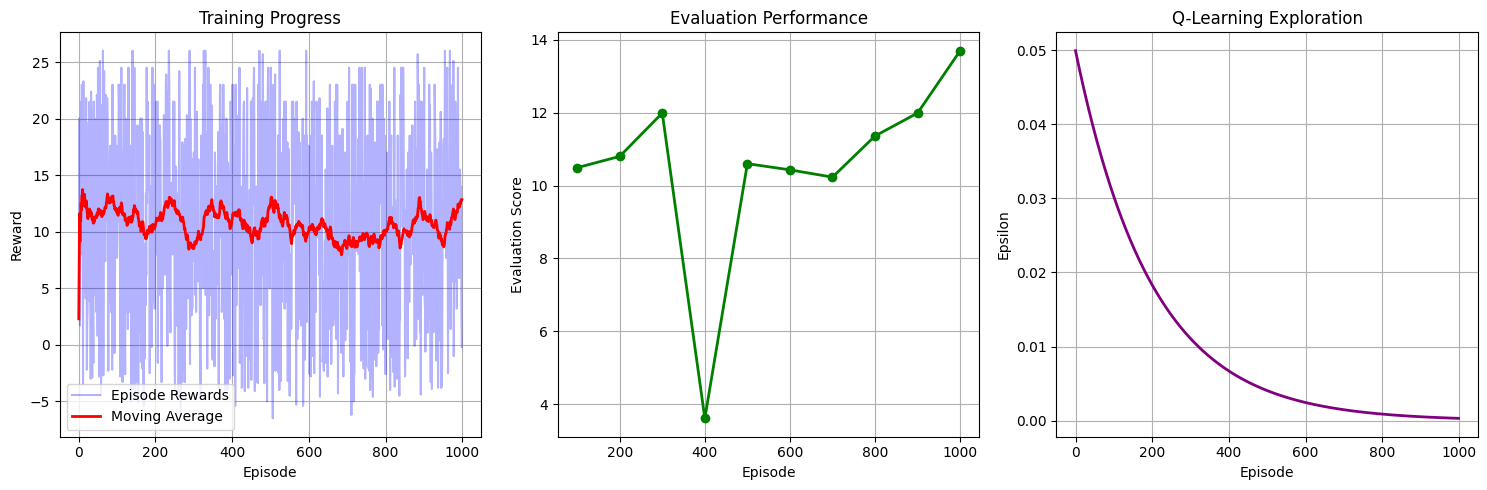

📊 Training Analysis Complete!


In [18]:
# Plot training progress
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(training_rewards, alpha=0.3, color='blue', label='Episode Rewards')
window = 50
moving_avg = [np.mean(training_rewards[max(0, i-window):i+1]) for i in range(len(training_rewards))]
plt.plot(moving_avg, color='red', linewidth=2, label='Moving Average')
plt.title('Training Progress')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
if evaluation_scores:
    eval_episodes = [i * EVALUATION_INTERVAL for i in range(1, len(evaluation_scores) + 1)]
    plt.plot(eval_episodes, evaluation_scores, 'go-', linewidth=2, markersize=6)
    plt.title('Evaluation Performance')
    plt.xlabel('Episode')
    plt.ylabel('Evaluation Score')
    plt.grid(True)

plt.subplot(1, 3, 3)
epsilon_history = [q_agent.epsilon * (q_agent.epsilon_decay ** i) for i in range(TRAINING_EPISODES)]
plt.plot(epsilon_history, 'purple', linewidth=2)
plt.title('Q-Learning Exploration')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid(True)

plt.tight_layout()
plt.show()

print("📊 Training Analysis Complete!")

In [19]:
# Final evaluation and model saving
print("🎯 Final Comprehensive Evaluation...")

final_evaluation = training_manager.evaluate_agents(num_episodes=50)
training_summary = training_manager.get_training_summary()

print(f"\n📈 Training Summary:")
print(f"   Total Episodes: {training_summary['total_episodes']}")
print(f"   Final Reward: {training_summary['final_reward']:.3f}")
print(f"   Best Reward: {training_summary['best_reward']:.3f}")
print(f"   Final Evaluation Score: {final_evaluation:.3f}")

print(f"\n🤖 Q-Learning Agent Stats:")
q_stats = training_summary['q_agent_stats']
print(f"   Q-Table Size: {q_stats['q_table_size']} states")
print(f"   Final Epsilon: {q_stats['epsilon']:.3f}")

print(f"\n🧠 Policy Gradient Agent Stats:")
pg_stats = training_summary['pg_agent_stats']
print(f"   Average Return: {pg_stats['avg_return']:.3f}")
print(f"   Recent Average: {pg_stats['recent_avg_return']:.3f}")

# Save final trained models
print("\n💾 Saving Final Trained Models...")
training_manager.save_models("final_trained_models")

# List downloadable files
print("\n📦 Downloadable Files Created:")
model_files = []
for file in os.listdir('.'):
    if file.endswith(('.pkl', '.pth')):
        model_files.append(file)
        print(f"   ✅ {file}")

print(f"\n🎉 Training Complete! {len(model_files)} model files ready for download.")
print("\n📋 Next Steps:")
print("1. Download the .pkl and .pth files from this Colab")
print("2. Create a 'models' folder in your local backend directory")
print("3. Place the downloaded files in backend/models/")
print("4. Restart your local server - it will automatically use the trained models!")
print("\n🚀 Your Adaptive Tutorial Agent is now powered by trained RL models!")

🎯 Final Comprehensive Evaluation...

📈 Training Summary:
   Total Episodes: 1000
   Final Reward: -0.200
   Best Reward: 26.000
   Final Evaluation Score: 9.936

🤖 Q-Learning Agent Stats:
   Q-Table Size: 18955 states
   Final Epsilon: 0.050

🧠 Policy Gradient Agent Stats:
   Average Return: 10.701
   Recent Average: 9.040

💾 Saving Final Trained Models...
💾 Q-Learning model saved to final_trained_models_q_learning.pkl
💾 Policy Gradient model saved to final_trained_models_policy_gradient.pth
💾 Models saved with prefix: final_trained_models

📦 Downloadable Files Created:
   ✅ final_trained_models_policy_gradient.pth
   ✅ checkpoint_400_q_learning.pkl
   ✅ checkpoint_1000_q_learning.pkl
   ✅ checkpoint_200_q_learning.pkl
   ✅ checkpoint_400_policy_gradient.pth
   ✅ checkpoint_800_q_learning.pkl
   ✅ checkpoint_200_policy_gradient.pth
   ✅ checkpoint_600_q_learning.pkl
   ✅ final_trained_models_q_learning.pkl
   ✅ checkpoint_800_policy_gradient.pth
   ✅ checkpoint_600_policy_gradient.pth


In [20]:
# Demo: Test the trained agents
print("🧪 Testing Trained Agents with Sample Session...")

test_env = TutorialEnvironment(topics, difficulty_levels, question_types)
state = test_env.reset()

print("\n🎓 Sample Adaptive Learning Session:")
print("Student Profile:", {k: f"{v:.2f}" if isinstance(v, float) else v for k, v in test_env.student_profile.items()})
print("\nAgent Decisions:")

for step in range(8):
    q_action = q_agent.get_action(state, training=False)
    pg_action = pg_agent.get_action(state, training=False)
    q_action_name = q_agent.action_names[q_action]
    pg_action_name = pg_agent.action_names[pg_action]

    print(f"Step {step + 1}: Q-Learning={q_action_name:15s} | Policy-Grad={pg_action_name:20s}")

    state, reward, done, info = test_env.step(q_action, pg_action)
    print(f"         Result: {'✅ Correct' if info['correct'] else '❌ Wrong':10s} | Topic={info['current_topic']:10s} | Difficulty={info['current_difficulty']}")

    if done:
        break

print(f"\n📊 Session Results:")
print(f"   Questions Answered: {test_env.questions_answered}")
print(f"   Final Accuracy: {test_env.correct_answers / test_env.questions_answered:.1%}")
print(f"   Final Engagement: {test_env.student_profile['engagement']:.2f}")

print("\n✅ Agent Demo Complete! The trained models show adaptive behavior.")

🧪 Testing Trained Agents with Sample Session...
🌍 Tutorial Environment initialized with 4 topics

🎓 Sample Adaptive Learning Session:
Student Profile: {'knowledge_level': '0.42', 'engagement': '0.55', 'difficulty_preference': '0.30', 'learning_pace': '0.50'}

Agent Decisions:
Step 1: Q-Learning=decrease_difficulty | Policy-Grad=prerequisite_check  
         Result: ✅ Correct  | Topic=Science    | Difficulty=beginner
Step 2: Q-Learning=decrease_difficulty | Policy-Grad=prerequisite_check  
         Result: ✅ Correct  | Topic=Science    | Difficulty=beginner
Step 3: Q-Learning=decrease_difficulty | Policy-Grad=prerequisite_check  
         Result: ❌ Wrong    | Topic=Science    | Difficulty=beginner
Step 4: Q-Learning=decrease_difficulty | Policy-Grad=prerequisite_check  
         Result: ✅ Correct  | Topic=Science    | Difficulty=beginner
Step 5: Q-Learning=decrease_difficulty | Policy-Grad=prerequisite_check  
         Result: ✅ Correct  | Topic=Science    | Difficulty=beginner
Step 6: 